# Transfer Learning - Part 2
### Fine Tuning

A very powerful technique in Deep Learning is the use of Transfer Learning which leverages architectures of existing models trained on a similar set to the problem at hand, and build a model from that model.

1. Can leverage an existing neural network architecture proven to work on problems similar to the one in hand.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

For this part, I am going to look at only 10% of the same food image dataset done on the convolutional neural networks notebook. 

* https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/
* https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

## Imports

In [1]:
import datetime
import logging
import os
import pathlib
import random
import sys
from typing import Tuple

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from py_learning_toolbox import data_toolbox
from py_learning_toolbox import ml_toolbox
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_hub as hub

## Environment

Setting up the environment and analyzing the various information associated with this notebook.

In [2]:
print(f'Notebook last run (end-to-end): {datetime.datetime.now()}')

Notebook last run (end-to-end): 2023-09-20 13:06:51.493904


In [3]:
tf.__version__

'2.13.0'

In [4]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:
# Setting up logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Global Constants

In [6]:
RANDOM_SEED = 42
IMAGE_SIZE = 224

## Downloading, Analyzing, & Creating Datasets

The dataset used is the Food 101 dataset commonly used to to explore Computer Vision. For simplicity of getting started with Computer Vision, I am only going to be looking at ten image classes to work quickly with a smaller dataset before applying learnings to the larger dataset.

* https://www.kaggle.com/datasets/dansbecker/food-101 (original kaggle page of dataset)
* https://github.com/mrdbourke/tensorflow-deep-learning/ (getting the modified dataset)

### Downloading & Analyzing Data

In [7]:
# Image dataset location
all_data_directory = pathlib.Path('./data/food-101/10_food_classes_all_data')
all_train_directory = all_data_directory / 'train'

ten_percent_data_directory = pathlib.Path('./data/food-101/10_food_classes_10_percent')
ten_percent_train_directory = ten_percent_data_directory / 'train'

one_percent_data_directory = pathlib.Path('./data/food-101/10_food_classes_1_percent')
one_percent_train_directory = one_percent_data_directory / 'train'

test_directory = all_data_directory / 'test'  # Same for both datasets

In [8]:
ml_toolbox.analysis.image.summarize_directory(all_data_directory)

INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_all_data/test/ice_cream Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_all_data/test/chicken_curry Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_all_data/test/steak Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_all_data/test/sushi Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_all_data/test/chicken_wings Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_all_data/test/grilled_salmon Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_all_data/test/hamburger Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Direct

In [9]:
ml_toolbox.analysis.image.summarize_directory(ten_percent_data_directory)

INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_10_percent/test/ice_cream Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_10_percent/test/chicken_curry Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_10_percent/test/steak Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_10_percent/test/sushi Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_10_percent/test/chicken_wings Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_10_percent/test/grilled_salmon Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_10_percent/test/hamburger Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysi

In [10]:
ml_toolbox.analysis.image.summarize_directory(one_percent_data_directory)

INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_1_percent/test/ice_cream Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_1_percent/test/chicken_curry Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_1_percent/test/steak Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_1_percent/test/sushi Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_1_percent/test/chicken_wings Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_1_percent/test/grilled_salmon Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image:Directory: data/food-101/10_food_classes_1_percent/test/hamburger Total Images: 250
INFO:py_learning_toolbox.ml_toolbox.analysis.image

In [11]:
# Getting the class names
class_names = ml_toolbox.analysis.image.get_classnames_from_directory(test_directory)
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

##### Dataset Findings

There are 10 total image classes, but instead of 750 images in all data (same as CNN notebooks), there are only 75 for each training dataset for 10% data, and only 7 for 1% data. The test data is the same size as the test set in the CNN notebook, which will allow us for a 1-to-1 comparison against the CNN notebook model.

### Creating Datasets

In [12]:
# Constants
BATCH_SIZE = 32

In [13]:
# Loading in the data
one_percent_train_data = tf.keras.utils.image_dataset_from_directory(str(one_percent_train_directory),
                                                                     image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                                     batch_size=BATCH_SIZE,
                                                                     label_mode='categorical')

ten_percent_train_data = tf.keras.utils.image_dataset_from_directory(str(ten_percent_train_directory),
                                                                     image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                                     batch_size=BATCH_SIZE,
                                                                     label_mode='categorical')

all_train_data = tf.keras.utils.image_dataset_from_directory(str(all_train_directory),
                                                             image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                             batch_size=BATCH_SIZE,
                                                             label_mode='categorical')

test_data = tf.keras.utils.image_dataset_from_directory(str(test_directory),
                                                        image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                        label_mode='categorical',
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=False)

Found 70 files belonging to 10 classes.
Found 750 files belonging to 10 classes.
Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [14]:
test_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [15]:
_, test_labels = data_toolbox.split_data_labels_from_dataset(test_data)
test_labels = tf.argmax(test_labels, axis=1)
test_labels

<tf.Tensor: shape=(2500,), dtype=int64, numpy=array([0, 0, 0, ..., 9, 9, 9])>

#### Findings:

* The data is not normalized.
* 10 class names
* 750 files for training and 2500 files for testing

## Feature Vector from Trained Model

Let's demonstrate the Global Average Pooling 2D Layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280), but when it passes through the GlobalAveragePooling2D layer, it turns into (None, 1280). This vector, (None, 1280), is our feature vector.

GlobalAveragePooling2D will transform a 4D Tensor into a 2D tensor. Al this does is grabs the mean of the middle two axes to condense the information into a lower dimensional feature vector.

### What is a feature vector?
A feature vector is a learned representation of the input data (a compressed form of the input data based on how the model see's it). For instance, the GlobalAveragePooling2D feature vectorization will grab the mean across dimensions, to condense all the information in those dimensions into a lower dimensional vector.

In [16]:
# setting random seed
tf.random.set_seed(RANDOM_SEED)

# input shape
input_shape = (1, 4, 4, 3)

# Create random tensor
input_tensor = tf.random.normal(input_shape)
print(f'Input Tensor: {input_tensor}')

# Global average pooling layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'Global Average Pooled Tensor: {global_average_pooled_tensor}')
print(f'Input Shape: {input_shape}')
print(f'Global Average 2D Shape: {global_average_pooled_tensor.shape}')

Input Tensor: [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]
Global Average Pooled Tensor: [[-0.09368646 -0.45840445 -0.28855976]]
Input Shape: (1, 4, 4, 3)
Global Average 2D Shape: (1, 3)


In [17]:
# Lets replicate the GlobalAveragePool2D
# Grabs the mean of the middle two axes to condense the information into a lower dimensional feature vector.
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

## Experiments

After seeing the incredible results that transfer learning can get with only 10% of the training data in the notebook, `Transfer Learning Part 1`, I want to see how will it will do with only 1% of the training data.

NOTE: Throughout all experiments, the same test dataset will be used to evaluate our model. This ensures consistancy accross validation metrics.

* Experiment-0: Baseline Model trained with 10% of the training data without data augmentation.
* Experiment-1: Use feature extraction transfer learning with 1% of the training data with data augmentation.
* Experiment-2: Use feature extraction transfer learning with 10% of the training data with data augmentation.
* Experiment-3: Use fine tuning transfer learning on 10% of the training data with data augmentation.
* Experiment-4: Use fine tuning transfer learning on 100% of the training data with data augmentation.

#### Model with Functional API Rather than Sequential API

The sequential api is straight forward, it runs the layers in sequential order. The functional api allows for more customizable models.

### Experiment Constants

In [18]:
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
OUTPUT_SIZE = 10

EPOCHS = 5
TRAIN_STEPS_PER_EPOCH_ALL = len(all_train_data)
TRAIN_STEPS_PER_EPOCH_10P = len(ten_percent_train_data)
TRAIN_STEPS_PER_EPOCH_1P = len(one_percent_train_data)

VAL_STEPS_PER_EPOCH = int(0.25 * len(test_data))

### Experiment Common Layers

A handful of layers are common across all experiments that I want to define for reuse.

#### Augmentation Layer

Augmenting data as a layer in the data model. Preprocessing and augmenting data can be done as a layer in the model.

Benefits:
* Data augmentation is done on the GPU instead of the CPU
* Image data augmentation is only done on the training data, so we can still export our model and use it elsewhere.

In [19]:
# Augmenting data as a layer in the data model
data_augmentation =  tf.keras.models.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255), Not required for the resnet transfer learning as it is already built in
], name='DataAugmentation')

#### Visualizing Augmentation Layer

(-0.5, 477.5, 445.5, -0.5)

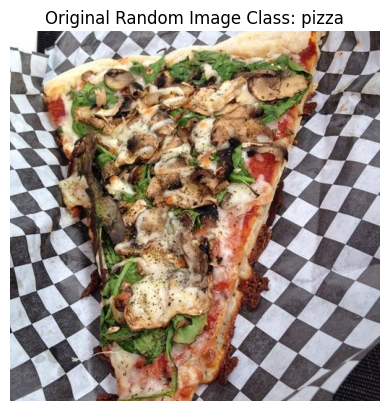

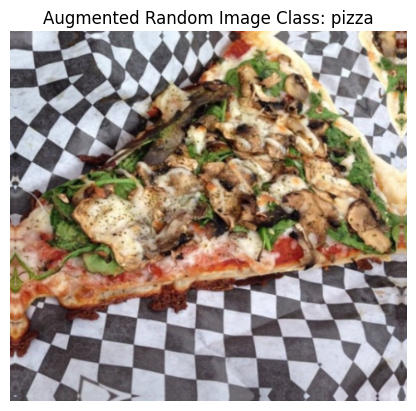

In [20]:
# Visualize our data augmentation code
# View random image and augment it through the data augmentation layer, and print view and after
target_class = random.choice(one_percent_train_data.class_names)
target_dir = str(one_percent_train_directory / target_class)

random_image = random.choice(os.listdir(target_dir))
random_image_path = f'{target_dir}/{random_image}'

img = mpimg.imread(random_image_path)
plt.figure()
plt.imshow(img)
plt.title(f'Original Random Image Class: {target_class}')
plt.axis(False)

augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow(augmented_img/255)  # NOTE: The augmented_img are not normalized so need to normalize it
plt.title(f'Augmented Random Image Class: {target_class}')
plt.axis(False)

### Experiment-0 (Baseline): EfficientNet Model w/ 10% Training Data without Data Augmentation

As a baseline model, I am going to use the EfficientNet architecture trained on 10% of the training data without performing in sort of data augmentation. This will be used to compare other models that incorporate changes in the data used to train the model such as more data or augmented data. 

In [21]:
# Constants
model_0_name = 'model_0_effnet_pool'

In [22]:
# 1. Create base model with tf.keras.applications models (starting from an existing model)
base_model_0 = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Need to freeze the base model (underlying pretrained patterns aren't updated while training)
base_model_0.trainable = False

# 3. Create the input layer
inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='InputLayer')

# 4. If using a model like ResNet50V2, you will need to normalize inputs.
#    Normalization layer (Not required for the EfficientNets because it is built into that model already)
# rescale = tf.keras.layers.Rescaling(1./255)(inputs)

# 5. Pass inputs into base_model
x = base_model_0(inputs)

# 6. Average pool the outputs of the base model (aggregate all the most important information).
x = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePoolingLayer')(x)

# 7. Create the output layer
outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='softmax', name='OutputLayer')(x)

# 8. Create model with the given inputs and outputs
model_0 = tf.keras.Model(inputs, outputs, name=model_0_name)

# 9. Compile Model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

# 10. Fit the model
model_0_history = model_0.fit(
    ten_percent_train_data,
    epochs=EPOCHS,
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH_10P,
    validation_data=test_data,
    validation_steps=VAL_STEPS_PER_EPOCH,
    callbacks=[
        ml_toolbox.modeling.callbacks.generate_tensorboard_callback(model_0_name),
    ])

INFO:py_learning_toolbox.ml_toolbox.modeling.callbacks:TensorBoard callback for logs/model_0_effnet_pool/20230920-130654
Epoch 1/5
24/24 [==============================] - 14s 519ms/step - loss: 1.8781 - accuracy: 0.4213 - val_loss: 1.4929 - val_accuracy: 0.5559
Epoch 2/5
24/24 [==============================] - 12s 495ms/step - loss: 1.0926 - accuracy: 0.7773 - val_loss: 0.9987 - val_accuracy: 0.7632
Epoch 3/5
24/24 [==============================] - 12s 496ms/step - loss: 0.7899 - accuracy: 0.8253 - val_loss: 0.8202 - val_accuracy: 0.7911
Epoch 4/5
24/24 [==============================] - 12s 499ms/step - loss: 0.6312 - accuracy: 0.8560 - val_loss: 0.7306 - val_accuracy: 0.7977
Epoch 5/5
24/24 [==============================] - 12s 501ms/step - loss: 0.5360 - accuracy: 0.8760 - val_loss: 0.6783 - val_accuracy: 0.8125


In [23]:
base_model_0.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [24]:
model_0.summary()

Model: "model_0_effnet_pool"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 GlobalAveragePoolingLayer   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 OutputLayer (Dense)         (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


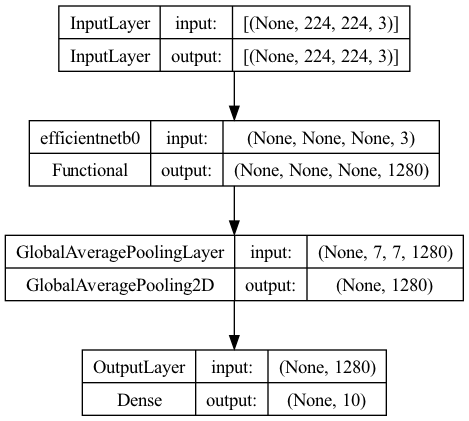

In [25]:
ml_toolbox.analysis.model.plot_model(model_0)

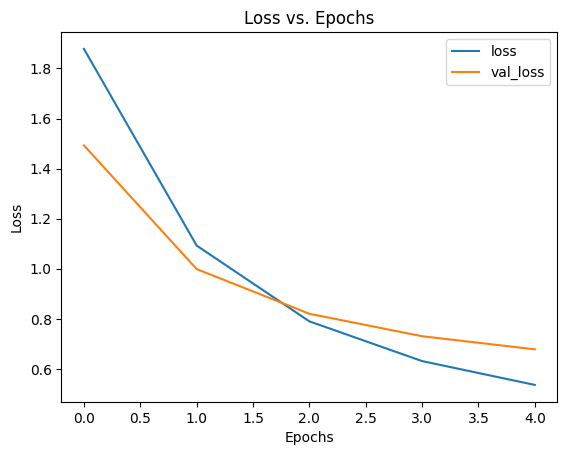

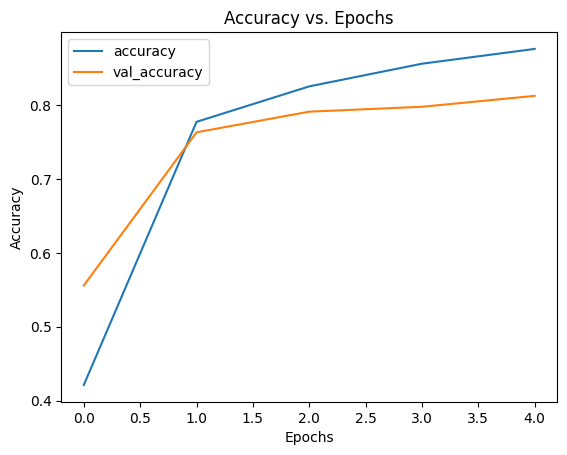

In [26]:
ml_toolbox.analysis.history.plot_history(model_0_history, metric='loss')
ml_toolbox.analysis.history.plot_history(model_0_history, metric='accuracy')

In [27]:
model_0_pred_probs = model_0.predict(test_data)
model_0_preds = tf.argmax(model_0_pred_probs, axis=1)

model_0_results = ml_toolbox.analysis.classification.generate_prediction_metrics(test_labels, model_0_preds, name=model_0_name)
model_0_results

79/79 [==============================] - 23s 288ms/step


ClassificationPredictionMetrics(accuracy=0.8588, precision=0.8619193487902854, recall=0.8588, f1=0.8593680167340421, name='model_0_effnet_pool')

### Experiment-1: Feature Extraction Transfer Learning with 1% of Training Data with Data Augmentation

I am going to train using only 1% of the data with Data Augmentation incorporated.

In [28]:
# Constants
model_1_name = 'model_1_effnet_1p_aug'

In [29]:
# Setup Input Shape and BaseModel
base_model_1 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_1.trainable = False

# InputLayer
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE, name='InputLayer')

# Augment Data Layer
x = data_augmentation(inputs)

# Efficient Net Layer
x = base_model_1(x, training=False)

# Pool the output
x = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePoolingLayer')(x)

# Output Layer
outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='softmax', name='OutputLayer')(x)

# Create Model
model_1 = tf.keras.models.Model(inputs, outputs, name=model_1_name)

# Compile Model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

# Fit Model
model_1_history = model_1.fit(
    one_percent_train_data,
    epochs=EPOCHS,
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH_1P,
    validation_data=test_data,
    validation_steps=VAL_STEPS_PER_EPOCH,
    callbacks=[
        ml_toolbox.modeling.callbacks.generate_tensorboard_callback(model_1_name),
    ]
)

INFO:py_learning_toolbox.ml_toolbox.modeling.callbacks:TensorBoard callback for logs/model_1_effnet_1p_aug/20230920-130821
Epoch 1/5
3/3 [==============================] - 9s 3s/step - loss: 2.2711 - accuracy: 0.1714 - val_loss: 2.0743 - val_accuracy: 0.2878
Epoch 2/5
3/3 [==============================] - 6s 3s/step - loss: 2.0375 - accuracy: 0.2714 - val_loss: 1.9333 - val_accuracy: 0.3865
Epoch 3/5
3/3 [==============================] - 6s 3s/step - loss: 1.8061 - accuracy: 0.4714 - val_loss: 1.8483 - val_accuracy: 0.4161
Epoch 4/5
3/3 [==============================] - 6s 3s/step - loss: 1.6299 - accuracy: 0.6000 - val_loss: 1.7892 - val_accuracy: 0.4342
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.4897 - accuracy: 0.7143 - val_loss: 1.7277 - val_accuracy: 0.4556


In [30]:
model_1.summary()

Model: "model_1_effnet_1p_aug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 DataAugmentation (Sequenti  (None, None, 3)           0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 GlobalAveragePoolingLayer   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 OutputLayer (Dense)         (None, 10)                12810     
                                             

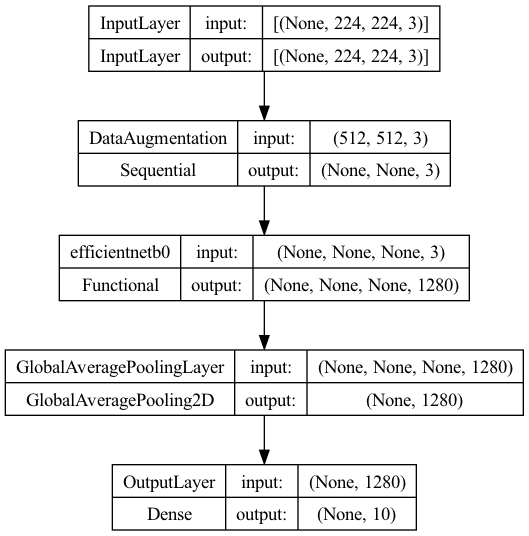

In [31]:
ml_toolbox.analysis.model.plot_model(model_1)

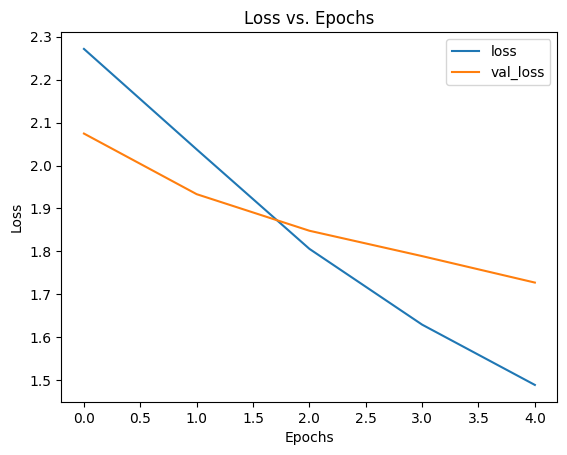

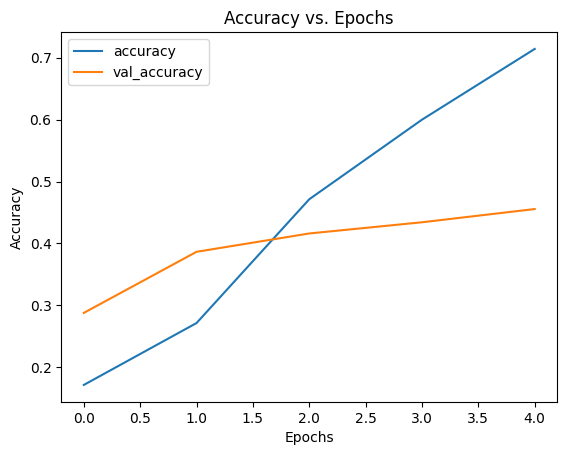

In [32]:
ml_toolbox.analysis.history.plot_history(model_1_history, metric='loss')
ml_toolbox.analysis.history.plot_history(model_1_history, metric='accuracy')

In [33]:
model_1_pred_probs = model_1.predict(test_data)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)

model_1_results = ml_toolbox.analysis.classification.generate_prediction_metrics(test_labels, model_1_preds, name=model_1_name)
model_1_results

79/79 [==============================] - 23s 290ms/step


ClassificationPredictionMetrics(accuracy=0.474, precision=0.5147302421840597, recall=0.474, f1=0.4640051329893609, name='model_1_effnet_1p_aug')

### Experiment-2: Feature Extraction Transfer Learning with 10% of Training Data with Data Augmentation

To better train models, I am going to introduce data augmentation with the same architecture and amount of data built in Experiment-0.

In [34]:
# Constants
model_2_name = 'model_2_effnet_10p_aug'

In [35]:
# Setup Input Shape and BaseModel
base_model_2 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_2.trainable = False

# InputLayer
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE, name='InputLayer')

# Augmentation Data Layer
x = data_augmentation(inputs)

# Efficient Net Layer
x = base_model_2(x, training=False)

# Pool the output
x = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePoolingLayer')(x)

# Output Layer
outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='softmax', name='OutputLayer')(x)

# Create Model
model_2 = tf.keras.models.Model(inputs, outputs, name=model_2_name)

# Compile Model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

# Create Model Checkpoint Callback
model_2_checkpoint_callback = ml_toolbox.modeling.callbacks.generate_checkpoint_callback(model_2_name, best_only=False)

# Fit Model (Using a model checkpoint callback to save weights during training)
model_2_history = model_2.fit(
    ten_percent_train_data,
    epochs=EPOCHS,
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH_10P,
    validation_data=test_data,
    validation_steps=VAL_STEPS_PER_EPOCH,
    callbacks=[
        model_2_checkpoint_callback,
        ml_toolbox.modeling.callbacks.generate_tensorboard_callback(model_2_name),
    ]
)

INFO:py_learning_toolbox.ml_toolbox.modeling.callbacks:Checkpoint callback for checkpoints/model_2_effnet_10p_aug/20230920-130920
INFO:py_learning_toolbox.ml_toolbox.modeling.callbacks:TensorBoard callback for logs/model_2_effnet_10p_aug/20230920-130920
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0589 - accuracy: 0.3093
Epoch 1: saving model to checkpoints/model_2_effnet_10p_aug/20230920-130920/checkpoint.ckpt
24/24 [==============================] - 15s 549ms/step - loss: 2.0589 - accuracy: 0.3093 - val_loss: 1.6594 - val_accuracy: 0.4589
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3559 - accuracy: 0.6773
Epoch 2: saving model to checkpoints/model_2_effnet_10p_aug/20230920-130920/checkpoint.ckpt
24/24 [==============================] - 12s 522ms/step - loss: 1.3559 - accuracy: 0.6773 - val_loss: 1.2798 - val_accuracy: 0.6151
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0136 - accuracy: 0.7653
Epoch 3: saving mod

In [36]:
model_2.summary()

Model: "model_2_effnet_10p_aug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 DataAugmentation (Sequenti  (None, None, 3)           0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 GlobalAveragePoolingLayer   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 OutputLayer (Dense)         (None, 10)                12810     
                                            

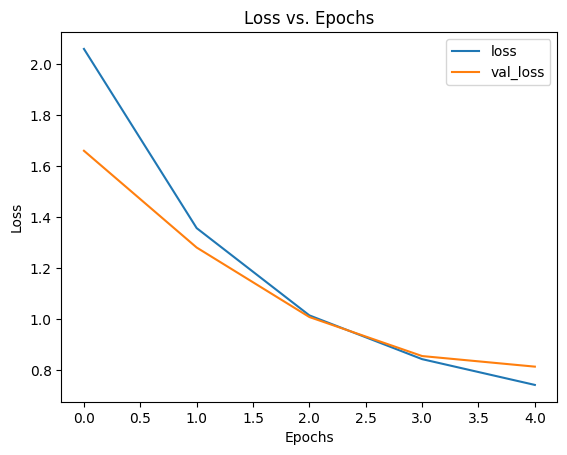

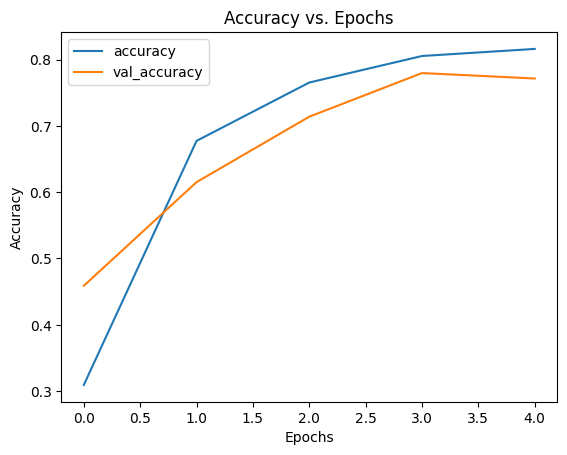

In [37]:
ml_toolbox.analysis.history.plot_history(model_2_history, metric='loss')
ml_toolbox.analysis.history.plot_history(model_2_history, metric='accuracy')

In [38]:
model_2_pred_probs = model_2.predict(test_data)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)

model_2_results = ml_toolbox.analysis.classification.generate_prediction_metrics(test_labels, model_2_preds, name=model_2_name)
model_2_results

79/79 [==============================] - 24s 295ms/step


ClassificationPredictionMetrics(accuracy=0.8448, precision=0.8523842409727833, recall=0.8448, f1=0.8441629480005358, name='model_2_effnet_10p_aug')

### Experiment-3: Fine Tuning Transfer Learning with 10% of Training Data with Data Augmentation

**NOTE**: Fine tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

For this model, the only thing that changes between model-2 and model-3 is that we are going to make the last 10 layers in the efficientnet model trainable. Per the note above, we need to start from a model with already trained output variables. To do this, we are going to use the already trained model-2, epoch 5 as a starting point, and train an additional 5 epochs with the last 10 layers of the efficientnet model being trainable.

In [39]:
# Constants
model_3_name = 'model_3_effnet_10p_aug_tuning'

INITIAL_EPOCHS = 5

In [40]:
# How many trainable variables are in base model
print('Total Trainable Variables: ', len(model_2.layers[2].trainable_variables))

Total Trainable Variables:  0


In [41]:
# Starting from model_2 to to continue training
# NOTE: I attempted cloning model_2 into model_3, and loading the weights from model 2 checkpoint
# but this was causing an error.

# Setting last 10 layers in base_model to True
base_model_2.trainable = True
for layer in base_model_2.layers[:-10]:
    layer.trainable = False

# Compile Model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

# How many trainable variables are in base model
print('Total Trainable Variables: ', len(base_model_2.trainable_variables))

Total Trainable Variables:  10


In [42]:
# Fit Model
model_3_history = model_2.fit(
    ten_percent_train_data,
    epochs=INITIAL_EPOCHS + EPOCHS,
    initial_epoch=model_2_history.epoch[-1],
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH_10P,
    validation_data=test_data,
    validation_steps=VAL_STEPS_PER_EPOCH,
    callbacks=[
        ml_toolbox.modeling.callbacks.generate_tensorboard_callback(model_3_name),
    ]
)

INFO:py_learning_toolbox.ml_toolbox.modeling.callbacks:TensorBoard callback for logs/model_3_effnet_10p_aug_tuning/20230920-131050
Epoch 5/10
24/24 [==============================] - 15s 560ms/step - loss: 0.6180 - accuracy: 0.8227 - val_loss: 0.6994 - val_accuracy: 0.7796
Epoch 6/10
24/24 [==============================] - 13s 558ms/step - loss: 0.4850 - accuracy: 0.8600 - val_loss: 0.6348 - val_accuracy: 0.7977
Epoch 7/10
24/24 [==============================] - 13s 541ms/step - loss: 0.4266 - accuracy: 0.8680 - val_loss: 0.6194 - val_accuracy: 0.8059
Epoch 8/10
24/24 [==============================] - 13s 558ms/step - loss: 0.4006 - accuracy: 0.8747 - val_loss: 0.6853 - val_accuracy: 0.7730
Epoch 9/10
24/24 [==============================] - 13s 561ms/step - loss: 0.3486 - accuracy: 0.8893 - val_loss: 0.6028 - val_accuracy: 0.8026
Epoch 10/10
24/24 [==============================] - 13s 553ms/step - loss: 0.3039 - accuracy: 0.9147 - val_loss: 0.6289 - val_accuracy: 0.7944


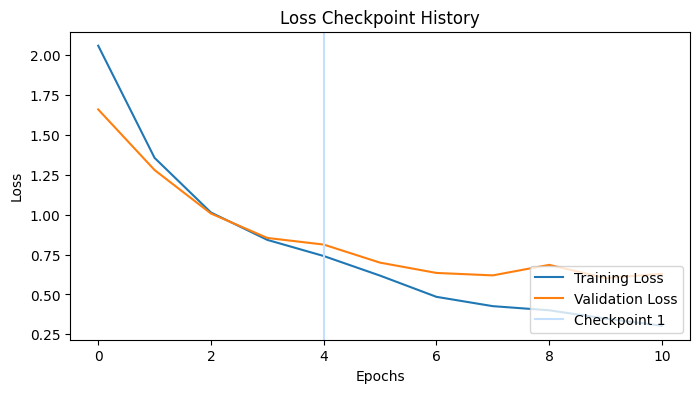

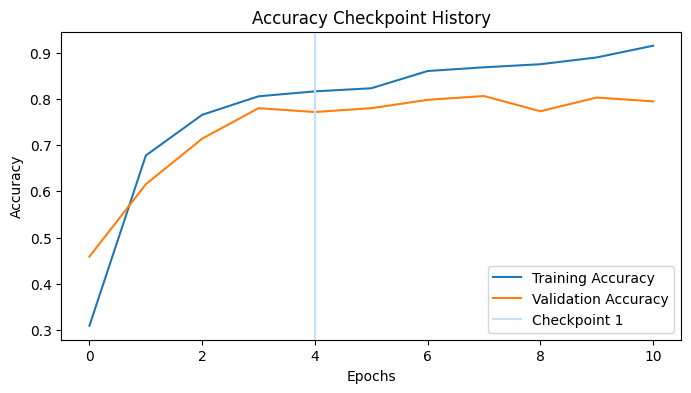

In [43]:
ml_toolbox.analysis.history.plot_sequential_histories([model_2_history, model_3_history], metric='loss', figsize=(8,4))
ml_toolbox.analysis.history.plot_sequential_histories([model_2_history, model_3_history], metric='accuracy', figsize=(8,4))

In [44]:
model_3_pred_probs = model_2.predict(test_data)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)

model_3_results = ml_toolbox.analysis.classification.generate_prediction_metrics(test_labels, model_3_preds, name=model_3_name)
model_3_results

79/79 [==============================] - 24s 296ms/step


ClassificationPredictionMetrics(accuracy=0.8632, precision=0.8684909308392847, recall=0.8632, f1=0.8638005214884019, name='model_3_effnet_10p_aug_tuning')

### Experiment-4: Fine Tuning Transfer Learning with 100% of Training Data with Data Augmentation

**NOTE**: Fine tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

For this model, the only thing that changes between model-2 and model-4 is that we are going to make the last 10 layers in the efficientnet model trainable. Per the note above, we need to start from a model with already trained output variables. To do this, we are going to use the already trained model-2, epoch 5 as a starting point, and train an additional 5 epochs with the last 10 layers of the efficientnet model being trainable.

To begin this, I need to revert model-2 back to the pre model-3 checkpoint.

In [45]:
# Constants
model_4_name = 'model_4_effnet_100p_aug_tuning'

INITIAL_EPOCHS = 5

In [46]:
# Going to start by reverting model 2 to the pre model-3 state in order to train model-4
model_2.load_weights(model_2_checkpoint_callback.filepath)
model_2.evaluate(test_data)

79/79 [==============================] - 24s 301ms/step - loss: 0.6278 - accuracy: 0.8448


[0.627809464931488, 0.8447999954223633]

In [47]:
# Verify the weights loaded in correctly
model_2_results.accuracy

0.8448

In [48]:
# Starting from model_2
# Setting last 10 layers in base_model to True
base_model_2.trainable = True
for layer in base_model_2.layers[:-10]:
    layer.trainable = False

# Compile Model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

model_2.summary()

Model: "model_2_effnet_10p_aug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 DataAugmentation (Sequenti  (None, None, 3)           0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 GlobalAveragePoolingLayer   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 OutputLayer (Dense)         (None, 10)                12810     
                                            

In [49]:
print('Total Trainable Variables: ', len(model_2.trainable_variables))

Total Trainable Variables:  12


In [50]:
# Fit Model
model_4_history = model_2.fit(
    all_train_data,
    epochs=INITIAL_EPOCHS + EPOCHS,
    initial_epoch=model_2_history.epoch[-1],
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH_ALL,
    validation_data=test_data,
    validation_steps=VAL_STEPS_PER_EPOCH,
    callbacks=[
        ml_toolbox.modeling.callbacks.generate_tensorboard_callback(model_4_name),
    ],
)

INFO:py_learning_toolbox.ml_toolbox.modeling.callbacks:TensorBoard callback for logs/model_4_effnet_100p_aug_tuning/20230920-131300
Epoch 5/10
235/235 [==============================] - 81s 335ms/step - loss: 0.6511 - accuracy: 0.7925 - val_loss: 0.4159 - val_accuracy: 0.8635
Epoch 6/10
235/235 [==============================] - 77s 328ms/step - loss: 0.5100 - accuracy: 0.8353 - val_loss: 0.4234 - val_accuracy: 0.8651
Epoch 7/10
235/235 [==============================] - 77s 327ms/step - loss: 0.4660 - accuracy: 0.8485 - val_loss: 0.3323 - val_accuracy: 0.8997
Epoch 8/10
235/235 [==============================] - 77s 328ms/step - loss: 0.4095 - accuracy: 0.8623 - val_loss: 0.3301 - val_accuracy: 0.8931
Epoch 9/10
235/235 [==============================] - 76s 324ms/step - loss: 0.3788 - accuracy: 0.8799 - val_loss: 0.3046 - val_accuracy: 0.9079
Epoch 10/10
235/235 [==============================] - 77s 327ms/step - loss: 0.3495 - accuracy: 0.8881 - val_loss: 0.2830 - val_accuracy: 0.90

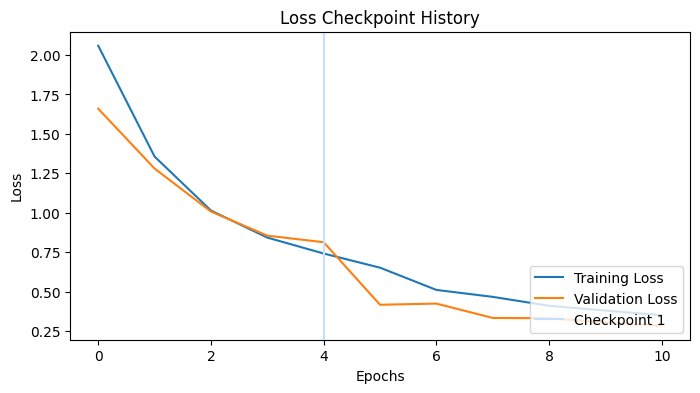

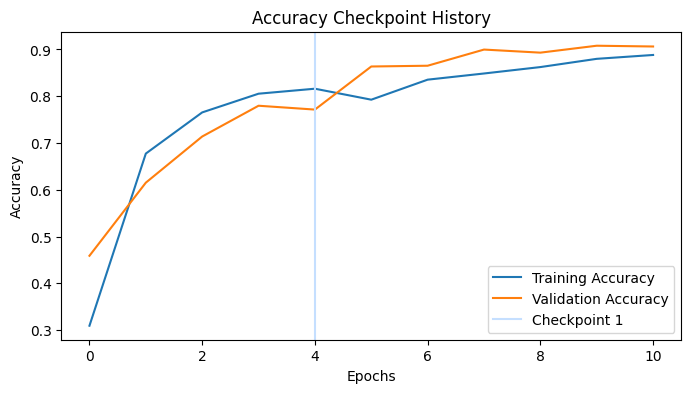

In [51]:
ml_toolbox.analysis.history.plot_sequential_histories([model_2_history, model_4_history], metric='loss', figsize=(8,4))
ml_toolbox.analysis.history.plot_sequential_histories([model_2_history, model_4_history], metric='accuracy', figsize=(8,4))

In [52]:
model_4_pred_probs = model_2.predict(test_data)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)

model_4_results = ml_toolbox.analysis.classification.generate_prediction_metrics(test_labels, model_4_preds, name=model_4_name)
model_4_results

79/79 [==============================] - 23s 283ms/step


ClassificationPredictionMetrics(accuracy=0.9116, precision=0.9137991970074774, recall=0.9116, f1=0.9116225514145101, name='model_4_effnet_100p_aug_tuning')

## Analysis

After running through 5 experiments that utilize transfer learning and the EfficientNet architecture, I want to compare how each separate training criteria affected the metrics of the model.

In [53]:
all_results = [
    model_0_results,
    model_1_results,
    model_2_results,
    model_3_results,
    model_4_results,
]
all_results_df = ml_toolbox.analysis.classification.generate_prediction_metrics_dataframe(all_results)
all_results_df

,accuracy,precision,recall,f1
model_0_effnet_pool,0.8588,0.861919,0.8588,0.859368
model_1_effnet_1p_aug,0.4740,0.514730,0.4740,0.464005
model_2_effnet_10p_aug,0.8448,0.852384,0.8448,0.844163
model_3_effnet_10p_aug_tuning,0.8632,0.868491,0.8632,0.863801
model_4_effnet_100p_aug_tuning,0.9116,0.913799,0.9116,0.911623


<Axes: >

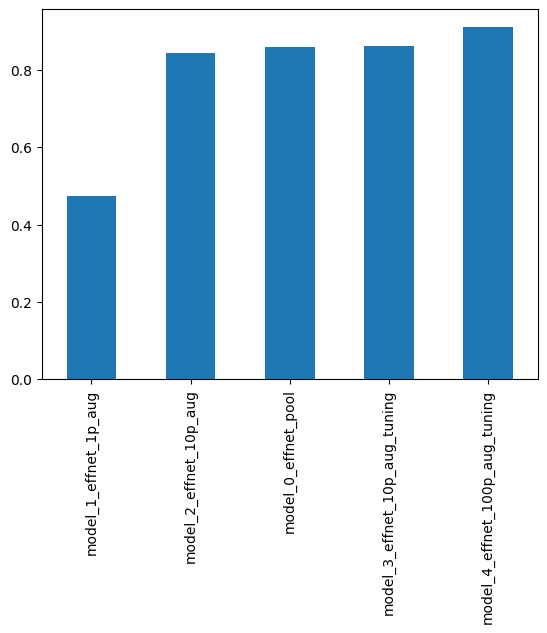

In [54]:
all_results_df['accuracy'].sort_values().plot(kind='bar')

##### Findings

As expected, the optimally performing model was the model trained on 100% of the dataset that included data augmentation and fine tuning, however, it is worth pointint out the accuracy of the other models. Even with only training with 10% or even just 1% of data, the accuracy was significantly better than working with a completely new CNN.